## Natural Language Processing with Disaster Tweets

### Step 1: Import necessary libraries

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

In [96]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

### Step 2: Load and mport the Dataset

In [97]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv("./data/test.csv")
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Step 3: Dataset Overview

In [98]:
print(train_data.shape)
print(test_data.shape)

(7613, 5)
(3263, 4)


In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [100]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [101]:
# Fill missing value for keyword and location cols

missing_cols = ['keyword', 'location']
for df in [train_data, test_data]:
    for col in missing_cols:
        df[col] = df[col].fillna('no_{}'.format(col))

In [102]:
train_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

**Target Variable Distribution**

<Axes: xlabel='target', ylabel='count'>

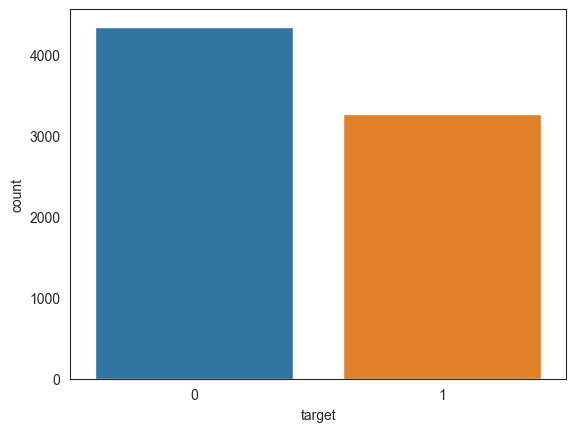

In [103]:
sns.countplot(x='target', data = train_data)

From this graph we can say that the data is almost balanced.

In [104]:
train_data['text length']= train_data['text'].apply(len)
train_data.sample(2)

,id,keyword,location,text,target,text length
804,1167,blight,"Vancouver, BC",@parksboardfacts first off it is the #ZippoLin...,0,139
1207,1739,buildings%20burning,Ziam af,Messi: has tattoos so he can't donate blood\r\...,1,103


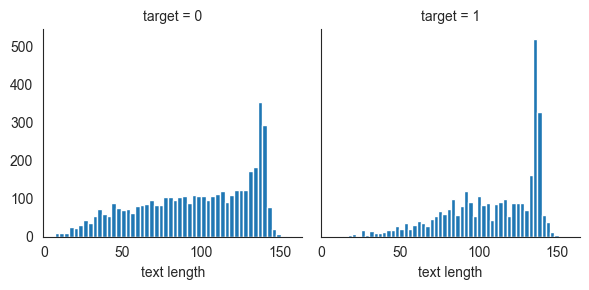

In [105]:
sns.set_style('white')
g = sns.FacetGrid(train_data, col='target')
g.map(plt.hist, 'text length', bins=50)

<Axes: xlabel='target', ylabel='text length'>

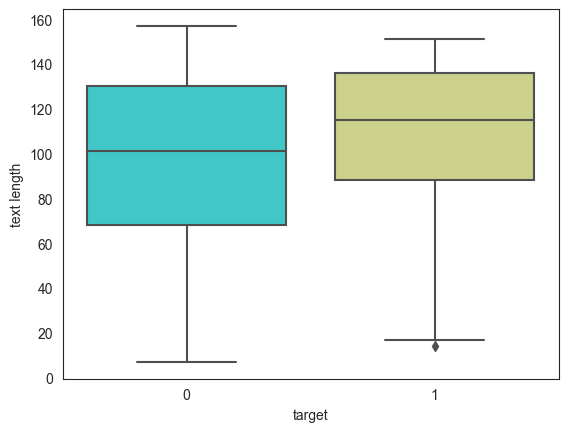

In [106]:
sns.boxplot(x = 'target', y='text length', data=train_data , palette='rainbow')

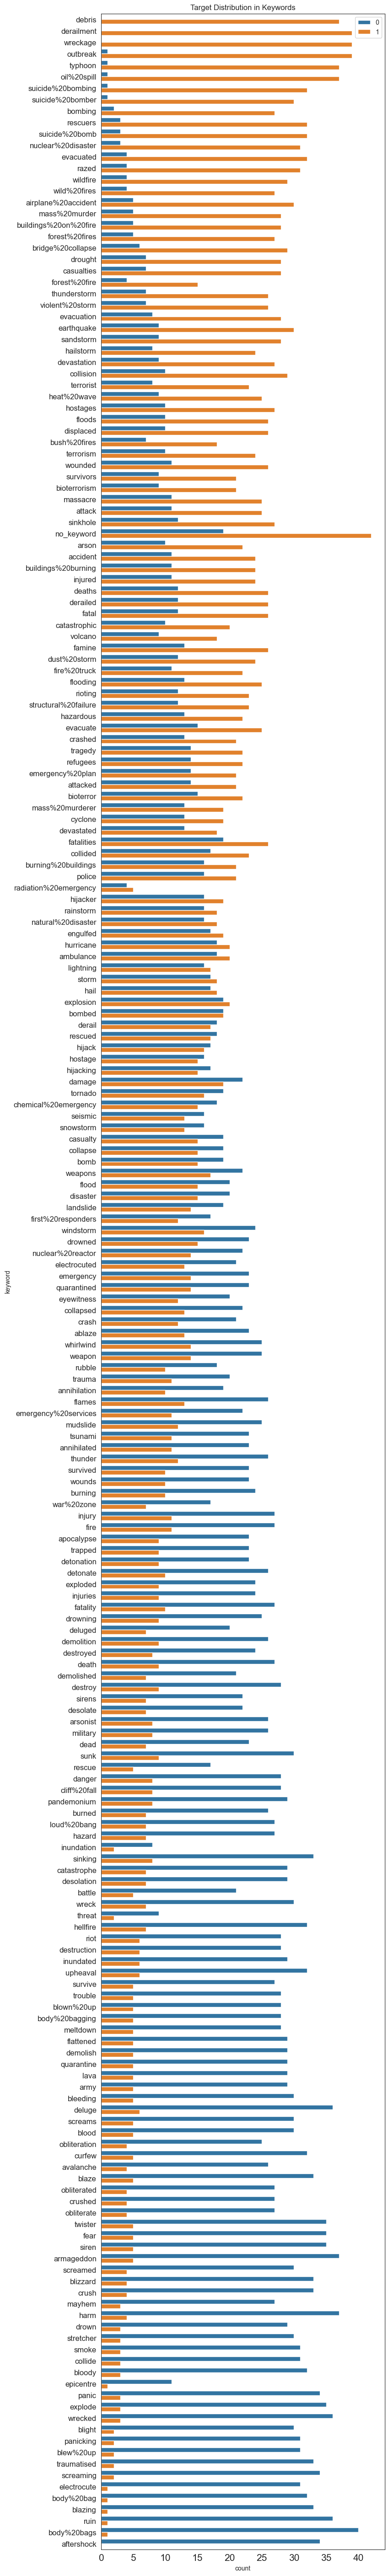

In [107]:
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_data.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_data.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_data.drop(columns=['target_mean'], inplace=True)

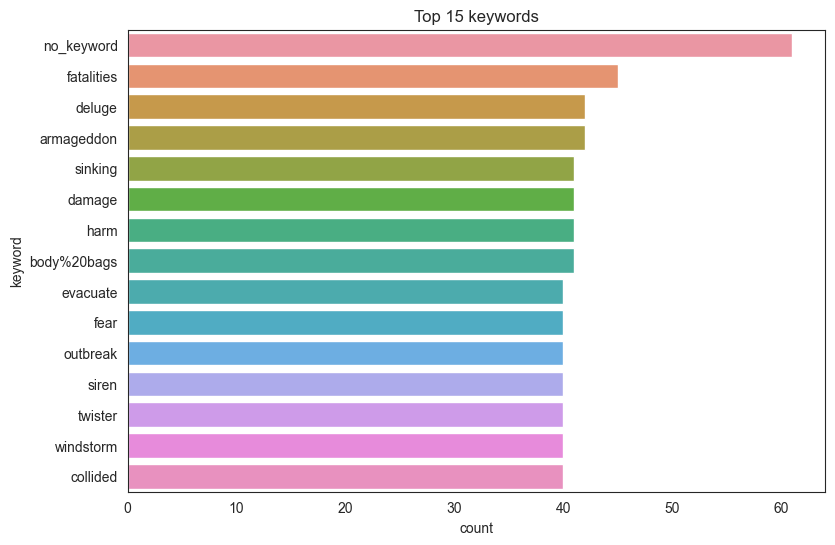

In [108]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_data.keyword, order = train_data.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

### Step 4 : Preprocessing

text pre-processing can be boiled down to these few simple steps:

* Tokenization - The process of mapping sentences from character to strings and strings into words are initially the basic step of any NLP problem because to understand any text or document we need to understand the meaning of the text by interpreting words/sentences present in the text.

* Stopwords - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detect relevant texts.

* Stemming - the process of reducing inflected (or sometimes derived) words to their word stem, base, or root form - generally a written form of the word

* Vectorization - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

**Data Cleaning Steps**

a. Remove newlines and Tabs

In [109]:
# Remove new lines \n and replace with space
train_data['clean_text_newline'] = train_data['text'].str.replace(r'\\n', ' ')

# Remove tabs \t and replace with space
train_data['clean_text_tab'] = train_data['clean_text_newline'].str.replace(r'\\t', ' ')

# Remove extra white spaces
train_data['clean_text_witheSpace'] = train_data['clean_text_tab'].apply(lambda x: re.sub(r'\s+', ' ', x))


b. Remove Punctuation/ Unicode characters/ Special Characters

In [110]:
# Encode to ASCII to remove non-ASCII characters
# Decode the ASCII-encoded bytes back to a string
train_data['clean_text_ascii'] = train_data['clean_text_witheSpace'].apply(lambda x: x.encode("ascii", "ignore").decode("ascii"))

In [111]:
# remove HTML tags
train_data['clean_text_tags'] = train_data['clean_text_ascii'].apply(lambda x: re.sub(r'https?://[a-zA-Z0-9\.\/\-_?=;&]*', '', x))
train_data['clean_text_tags'] = train_data['clean_text_tags'].apply(lambda x: re.sub(r'<[^>]+>', "", x))

In [112]:
unwanted_punc = ['"', "'", '=', '@', '&', '%', '.', ',', ':', '\\', '$', '^', '<', '>', '!', '?', '{', '}', 
                 ';', '\n', '\t', '(', ')', '[', ']', '/', '*', '+', '#', '\u200c', '\ufeff', '-', '_', '|']

# Define a function to remove unwanted punctuation
def remove_unwanted_punctuation(text):
    for punc in unwanted_punc:
        text = text.replace(punc, "")
    return text

# Apply the function to the 'text' column
train_data['clean_text_unwanted_punc'] = train_data['clean_text_tags'].apply(remove_unwanted_punctuation)


In [113]:
unwanted_digit = ['0','1','2','3','4','5','6','7','8','9']

for digit in unwanted_digit:
    train_data['clean_unwanted_digit'] = train_data['clean_text_unwanted_punc'].replace(digit, "")

c. Tokenization and remove stopwords

In [114]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nader\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [115]:
# Define a function to process text
def process_text(text):
    # Step 1: Tokenization
    tokens = word_tokenize(text)
    
    # Step 2: Convert to lowercase
    normal_tokens = [token.lower() for token in tokens]
    
    # Step 3: Remove stopwords
    clean_stop_words_tokens = [token for token in normal_tokens if token not in stopwords.words("english")]
    
    return clean_stop_words_tokens

# Apply the function to the 'clean_text' column
train_data['clean_stop_words_tokens'] = train_data['clean_unwanted_digit'].apply(process_text)


In [116]:
train_data[['text', 'clean_stop_words_tokens']]

,text,clean_stop_words_tokens
0,Our Deeds are the Reason of this #earthquake M...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...","[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...
7608,Two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, bridge, collapse..."
7609,@aria_ahrary @TheTawniest The out of control w...,"[ariaahrary, thetawniest, control, wild, fires..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[m194, 0104, utc5km, volcano, hawaii]"
7611,Police investigating after an e-bike collided ...,"[police, investigating, ebike, collided, car, ..."


d. Repeated characters reduction, for example: Hellllo → Hello

Sometimes in social networks, some of the main characters of a word are repeated several times to emphasize more. For example, the word frrrrrieeeeeeennnddss, we must return these words to their original form and remove the repeated character.

* We wrote a class to remove repeated parameters with name RepeatReplacer.
* For this operation, we use the wordnet corpus, which is a dictionary of English words.

In [117]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nader\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [118]:
class RepeatReplacer():
    def __init__(self):
        # The beginning and the end char of word can be anything, but there must be a repeated character in the middle
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)') 
        self.repl = r'\1\2\3' # 1: start chars + a char, 2: middle char, 3: end chars

    def replace(self, word):
        if(wordnet.synsets(word)): 
            return word # if the word was in wordnet returns that word.
            
        repl_word = self.repeat_regexp.sub(self.repl, word) # Delete a repeated character
        if(repl_word != word): 
            return self.replace(repl_word) # Recursive function
        else: 
            return repl_word # The word is not in word net

In [119]:
# Example usage:
replacer = RepeatReplacer()
test_token1 = "gooood"
replacer.replace(word = test_token1)


'good'

In [120]:
test_token2 = "Hellllo"
replacer.replace(word=test_token2)

'Hello'

In [121]:
#### It's wrong!!!!!

# Apply the lambda function
train_data['clean_text_Repeated_characters'] = train_data['clean_stop_words_tokens'].apply(lambda x: [replacer.replace(word=token) for token in x ])

# Check and print tokens that have been replaced
for index, row in train_data.iterrows():
     for token, clean in zip(row['clean_stop_words_tokens'], row['clean_text_Repeated_characters']):
         if token != clean:
             print(f"{token} => clean: {clean}")


13000 => clean: 130
goooooooaaaaaal => clean: goal
looooool => clean: lol
cooool => clean: cool
bbcmtd => clean: bcmtd
soooo => clean: so
carolinaablaze => clean: carolinablaze
alexissanchez => clean: alexisanchez
goodnight => clean: godnight
voortrekker => clean: vortreker
nashvilletraffic => clean: nashviletrafic
caraccidentlawyer => clean: caracidentlawyer
i77 => clean: i7
mooresville => clean: moresvile
iredell => clean: iredel
118 => clean: 18
sleepjunkies => clean: slepjunkies
cabrillo => clean: cabrilo
hwymagellan => clean: hwymagelan
110358 => clean: 10358
i77 => clean: i7
mooresville => clean: moresvile
iredell => clean: iredel
118 => clean: 18
accidentwho => clean: acidentwho
donnie => clean: donie
ashville => clean: ashvile
damagenhs999 => clean: damagenhs9
naayf => clean: nayf
chandanee => clean: chandane
mma => clean: ma
damagewpd1600 => clean: damagewpd160
aashiqui => clean: ashiqui
aggarwal => clean: agarwal
suffield => clean: sufield
i77 => clean: i7
southaccident => cl

f. Typo Correction/ Misspelled words: big “dada” → big “data”

Spelling errors happen a lot for various reasons such as proximity between keyboards and other reasons. In this section, we want to learn how to detect and correct it.

To spelling correction in this project, we used the autocorrect library.

In [123]:
! pip install autocorrect

In [124]:
from autocorrect import Speller

# Instantiate the Speller
speller = Speller()

print(speller("big dada"))

big data


In [126]:
train_data['clean_text_autocorrect'] = train_data['clean_text_Repeated_characters'].apply(lambda x: [speller(token) for token in x])

In [127]:
# Check and print tokens that have been replaced
for index, row in train_data.iterrows():
     for token, clean in zip(row['clean_text_Repeated_characters'], row['clean_text_autocorrect']):
         if token != clean:
             print(f"{token} => clean: {clean}")


allah => clean: alla
ronge => clean: range
sask => clean: task
cafire => clean: fire
manitou => clean: monitor
hah => clean: has
fvck => clean: fuck
bago => clean: ago
bago => clean: ago
wayi => clean: way
bcmtd => clean: cmd
mufc => clean: ufc
theyve => clean: theyre
abia => clean: asia
superintende => clean: superintendent
nsfw => clean: nsw
ancop => clean: anchor
tita => clean: tica
nsfw => clean: nsw
lanford => clean: afford
arsonist => clean: agonist
noches => clean: niches
godnight => clean: midnight
trampling => clean: traveling
turkmen => clean: turkey
turkmen => clean: turkey
diyala => clean: dial
tambo => clean: tab
peeps => clean: keeps
revel => clean: level
wmv => clean: wm
wmv => clean: wm
navista7 => clean: vista7
cuz => clean: cup
testicles => clean: textiles
pkwy => clean: play
stephenson => clean: stephens
iredel => clean: rebel
cabrilo => clean: carlo
iredel => clean: rebel
spilt => clean: split
donie => clean: done
overturns => clean: overturn
crashgt => clean: crash

g. lemmatization

Converting different forms of a word to the basic form of that word

* Delete extra characters from the beginning and end of the desired word
* Convert plural to singular
* Convert uppercase to lowercase
* Implementation of algorithms and linguistic commands to get to the root of the word

In [ ]:
lemmatizer = WordNetLemmatizer() # by default Part of speach is Noun or Name
print(lemmatizer.lemmatize("believes"))

In [ ]:
lemmatizer = WordNetLemmatizer() # by default Part of speach is Noun or Name

lem_tokens = []
for token in clean_spell_tokens:
    clean = lemmatizer.lemmatize(token)
    if clean != token: print(token, "=>", clean)
    lem_tokens.append(clean)

### Step 5: Detemine the Features & Target Variable

### Step 6: Split the DataSet to Train & Test

### Step 7: Train the Model using the X_train and y_train

### Step 8: Predicting Test Data

### Step 9: Evaluating the Model

### Model fitting with K-cross Validation and GridSearchCV